In [5]:
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

from IPython.display import clear_output
import matplotlib.pyplot as plt

import segmentation_models as sm

import tensorflow_addons as tfa
import cv2
import numpy as np
print(tfa.__version__)
import matplotlib
from matplotlib import pyplot
from matplotlib.image import imread

2.2.0
0.9.1


In [2]:
!pip install tensorflow_addons==0.11.2

  Using cached tensorflow_addons-0.11.2-cp36-cp36m-manylinux2010_x86_64.whl (1.1 MB)
  Attempting uninstall: tensorflow-addons
    Found existing installation: tensorflow-addons 0.9.1
    Uninstalling tensorflow-addons-0.9.1:
      Successfully uninstalled tensorflow-addons-0.9.1
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [6]:
def display(display_list, idx=None, only_inference=False, fig_size=15):
    """
    "only_inference" = True creates sample of inferenced image PNG file.
    """
    if only_inference:
        plt.figure(figsize=(fig_size,fig_size))
        #a = np.array(display_list)
        #a = a.astype(np.float32) * 255.0
        plt.imshow(display_list)
        plt.axis('off')
        plt.show()

        #cv2.imwrite("EX{}.png".format(idx), cv2.cvtColor(a, cv2.COLOR_RGB2BGR))
    
    else:
        plt.figure(figsize=(fig_size,fig_size))
        title = ['Input', 'True', 'Predcited']

        for i in range(len(display_list)):
            if i == 0 and display_list[0].shape[-1] == 1:
                COLOR = 'gray'
            else:
                COLOR = None
            plt.subplot(1, len(display_list), i+1)
            plt.title(title[i])
            plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]), cmap=COLOR)
            plt.axis('off')

        plt.show()
    

In [7]:
def create_mask(pred_mask, num=0):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[num]

def show_predictions(test_mode=False, x=None,y=None, num=1):
  if test_mode:
    print("In testing Mode...")
    for i in range(num):
      pred_mask = model.predict(x, batch_size=1)
      #print(np.unique(np.round(y[i])))
      #print(pred_mask.shape) #20, img_size, 5
      #circle = np.round(tf.expand_dims(pred_mask[i,:,:,1], -1))
      display([x[i], y[i], create_mask(pred_mask, num=i)])

  else:
    #ans = np.argmax(model.predict(sample_image2[tf.newaxis, ...]), -1)
    #ans = tf.expand_dims(ans,-1)[0]
    #print(np.unique(ans))
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])
    
    display([sample_image2, sample_mask2, 
            create_mask(model.predict(sample_image2[tf.newaxis, ...]))])

In [8]:
#Compile Options
ACTIVATION = "softmax"
FROM_LOGITS = False 
OPTIMIZER = "RMSprop" 
LR = 0.0001 #0.0001
ENC_FREEZE = False
BACKBONE = 'inceptionv3'

#Fit options
EPOCHS = 100
BATCH_SIZE = 2
NUM_VAL = 20
F_EPOCHS = 20
RGB = False

#Other
IMG_SIZE = (960, 1152) #(1248, 480) #480,576 #960, 1152 #480 576 
STEPS_PER_EPOCH = 30

In [9]:
def onehot_to_rgb(one_hot):

    channel_0 = np.zeros(IMG_SIZE + (1,)) #prediction
    channel_1 = np.zeros(IMG_SIZE + (1,))
    channel_2 = np.zeros(IMG_SIZE + (1,))
    
    ex = one_hot # ex = H,W,1

    #pushed = tf.expand_dims(ex[:,:,1], -1) + tf.expand_dims(ex[:,:,2], -1)
    #circle = tf.expand_dims(ex[:,:,3], -1)
    #stamped = tf.expand_dims(ex[:,:,2], -1) # stamped = H,W,1
    #bg = tf.expand_dims(ex[:,:,0], -1)
    #hole = tf.expand_dims(ex[:,:,4], -1)

    channel_0[ex==1] = color_dict[1][0]
    channel_1[ex==1] = color_dict[1][1]
    channel_2[ex==1] = color_dict[1][2]

    channel_0[ex==3] = color_dict[3][0]
    channel_1[ex==3] = color_dict[3][1]
    channel_2[ex==3] = color_dict[3][2]

    channel_0[ex==2] = color_dict[2][0]
    channel_1[ex==2] = color_dict[2][1]
    channel_2[ex==2] = color_dict[2][2]

    channel_0[ex==0] = color_dict[0][0]
    channel_1[ex==0] = color_dict[0][1]
    channel_2[ex==0] = color_dict[0][2]
    
    channel_0[ex==4] = color_dict[4][0]
    channel_1[ex==4] = color_dict[4][1]
    channel_2[ex==4] = color_dict[4][2]
    
    channel_0[ex==5] = color_dict[5][0]
    channel_1[ex==5] = color_dict[5][1]
    channel_2[ex==5] = color_dict[5][2]
    
    channel_0[ex==6] = color_dict[6][0]
    channel_1[ex==6] = color_dict[6][1]
    channel_2[ex==6] = color_dict[6][2]
    
    

    com = tf.concat([channel_0, channel_1, channel_2], -1)

    display(com, only_inference=True,fig_size=10)

Get One sample & get unique colors

In [10]:
loc = "../../data/LGES_Vision/JR_Bottom/0.Data/211110_3rd_data/"
mask = cv2.imread(loc + 'Mask_Image/[2021-10-13]11.25.55.086_1_2_Image.png') #2048 x 2448
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB) / 255.0

sample = cv2.imread(loc + 'Original_Image/[2021-10-13]11.25.55.086_1_2_Image.png', 0)
sample = tf.expand_dims(sample,-1)

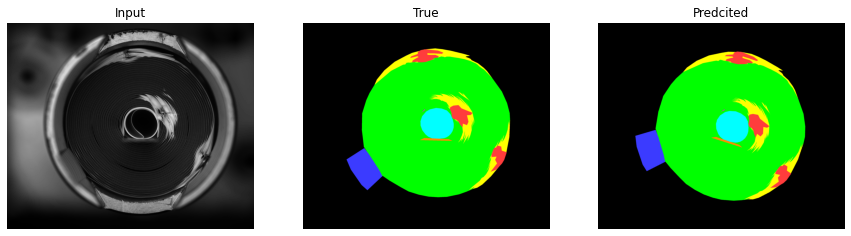

In [19]:
b_img = tf.image.adjust_brightness(sample, 0.4)
rot = tfa.image.rotate(mask, 6)
display([sample, mask, rot])

In [20]:
tri = cv2.inRange(mask, (.99, 0, .99), (1,0,1))
mask[tri != 0] = [0,1,0]

colors = np.unique(tf.reshape(mask,[-1,3]), axis=0)

In [21]:
color_dict = {i: list(x) for i,x in enumerate(colors)}

#1,1,0: Yellow 0,1,0 Green 101 pink, 000b 011 cyan 100 Red 
# 0 bg, 1 Circle 2 hole 3 small 4 stamp 5 psuhed 
# 0 bg, 1 Battery 2 hole 3 pressed 4 dent 
color_dict[6] = color_dict[3]
color_dict[3] = [1,1,0]

print(color_dict)

def rgb_to_onehot(rgb_arr, color_dict):
    num_classes = len(color_dict)
    shape = rgb_arr.shape[:2] + (num_classes,)
    arr = np.zeros(shape, dtype=np.int32)
    for i, cls in enumerate(color_dict):
        arr[:, :, i] = np.all(rgb_arr.reshape((-1, 3)) == color_dict[i], axis=1).reshape(shape[:2])
    return arr

{0: [0.0, 0.0, 0.0], 1: [0.0, 1.0, 0.0], 2: [0.0, 1.0, 1.0], 3: [1, 1, 0], 4: [1.0, 0.23529411764705882, 0.23529411764705882], 5: [1.0, 0.5490196078431373, 0.0], 6: [0.23137254901960785, 0.23137254901960785, 1.0]}


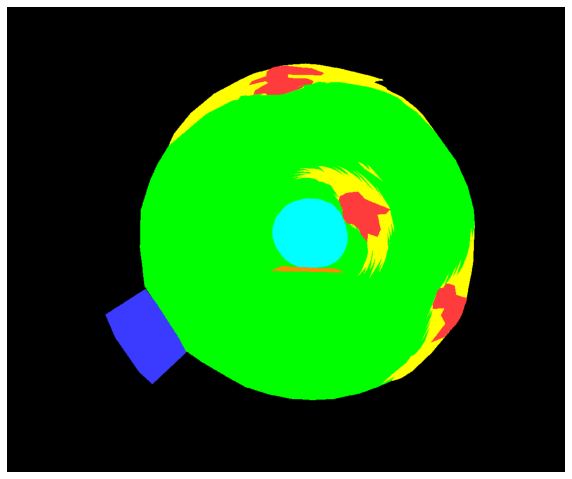

In [22]:
a = rgb_to_onehot(mask,color_dict)

bb = tf.expand_dims(np.argmax(a, axis=-1),-1)
bbb = tf.image.resize(bb, IMG_SIZE, antialias = True, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR) #480, 576 960,1152
 # 2048 x 2448
    
onehot_to_rgb(bbb)

In [23]:
val_x = []
val_y = []
train_x = []
train_y = []

with open("Val_img.txt") as f:
    for idx,line in enumerate(f):
        img = line.splitlines()[0]
        
        if RGB:
            n = cv2.imread(loc + "Original_Image/" + img)
        else:
            n = cv2.imread(loc + "Original_Image/" + img, 0)
            n = tf.expand_dims(n,-1)
            
        b_img = tf.image.adjust_brightness(n, 0.4)

        n = tf.cast(n, tf.float32) / 255.0
        b_img = tf.cast(b_img, tf.float32) / 255.0

        n = tf.image.resize(n, IMG_SIZE, antialias = True, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        b_img = tf.image.resize(b_img, IMG_SIZE, antialias = True, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

        if idx > 9:
            angles = np.random.uniform(0, 2*np.pi, 3)
            
            flipped_img = tfa.image.rotate(n, angles[0])
            #flipped_img1 = tfa.image.rotate(n, angles[1])
            #flipped_img2 = tfa.image.rotate(n, angles[2])
            
            b_flipped_img = tfa.image.rotate(b_img, angles[0])
            #b_flipped_img1 = tfa.image.rotate(b_img, angles[1])
            
            train_x.append(n)
            train_x.append(b_img)
            train_x.append(b_flipped_img)
            #train_x.append(b_flipped_img1)
            train_x.append(flipped_img)
            #train_x.append(flipped_img1)
            #train_x.append(flipped_img2)
            
            y = cv2.imread(loc + "Mask_Image/" + img) # imread(dir+file_name+".png")
            y = cv2.cvtColor(y, cv2.COLOR_BGR2RGB) / 255.0
            
            cc = cv2.inRange(y, (.99, 0, .99), (1,0,1))

            y[cc != 0] = [0,1,0]
            a = rgb_to_onehot(y, color_dict) #change to one hot

            bb = tf.expand_dims(np.argmax(a, axis=-1),-1) #combine one hot
            mask = tf.image.resize(bb, IMG_SIZE, antialias = True, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
            mask = np.round(mask)

            flipped_mask = tfa.image.rotate(mask, angles[0])
            #flipped_mask1 = tfa.image.rotate(mask, angles[1])
            #flipped_mask2 = tfa.image.rotate(mask, angles[2])

            train_y.append(mask)
            train_y.append(mask)
            train_y.append(flipped_mask)
            #train_y.append(flipped_mask1)
            train_y.append(flipped_mask)
            #train_y.append(flipped_mask1)
            #train_y.append(flipped_mask2)
            
            continue
        
        val_x.append(b_img)
        val_x.append(n)
        #MASK
        y = cv2.imread(loc + "Mask_Image/" + img) # imread(dir+file_name+".png")
        y = cv2.cvtColor(y, cv2.COLOR_BGR2RGB) / 255.0
        tri = cv2.inRange(y, (.99, 0, .99), (1,0,1))
        y[tri != 0] = [0,1,0]

        a = rgb_to_onehot(y, color_dict) #change to one hot

        bb = tf.expand_dims(np.argmax(a, axis=-1),-1) #combine one hot
        mask = tf.image.resize(bb, IMG_SIZE, antialias = True, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        mask = np.round(mask)

        val_y.append(mask)
        val_y.append(mask)
        
val_x = tf.convert_to_tensor(val_x)
val_y = tf.convert_to_tensor(val_y)

print(val_x.shape, np.max(val_x))
print(val_y.shape, np.max(val_y))        

(20, 960, 1152, 1) 1.0
(20, 960, 1152, 1) 6


In [24]:
with open("Train_img.txt") as f:
    for line in f:
        img = line.splitlines()[0]
        #angles to rotate
        angles = np.random.uniform(0, 2*np.pi, 3)

        #Image
        
        if RGB:
            n = cv2.imread(loc + "Original_Image/" + img)
        else:
            n = cv2.imread(loc + "Original_Image/" + img, 0)
            n = tf.expand_dims(n,-1)
            
        b_img = tf.image.adjust_brightness(n, 0.4)

        #NORMALIZE
        b_img = tf.cast(b_img, tf.float32) / 255.0
        n = tf.cast(n, tf.float32) / 255.0

        #RESIZE
        n = tf.image.resize(n, IMG_SIZE, antialias = True, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        b_img = tf.image.resize(b_img, IMG_SIZE, antialias = True, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)


        #AUGMENTATION
        flipped_img = tfa.image.rotate(n, angles[0])
        flipped_img1 = tfa.image.rotate(n, angles[1])
        #flipped_img2 = tfa.image.rotate(n, angles[2])
        
        b_flipped_img = tfa.image.rotate(b_img, angles[0])
        #b_flipped_img1 = tfa.image.rotate(b_img, angles[1])

        train_x.append(n)
        train_x.append(b_img)
        train_x.append(b_flipped_img)
        #train_x.append(b_flipped_img1)
        train_x.append(flipped_img)
        train_x.append(flipped_img1)
        #train_x.append(flipped_img2)

        #MASK
        y = cv2.imread(loc + "Mask_Image/" + img) # imread(dir+file_name+".png")
        y = cv2.cvtColor(y, cv2.COLOR_BGR2RGB) / 255.0
        
        tri = cv2.inRange(y, (.99, 0, .99), (1,0,1))
        y[tri != 0] = [0,1,0]
        a = rgb_to_onehot(y, color_dict) #change to one hot

        bb = tf.expand_dims(np.argmax(a, axis=-1),-1) #combine one hot
        mask = tf.image.resize(bb, IMG_SIZE, antialias = True, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        mask = np.round(mask)

        flipped_mask = tfa.image.rotate(mask, angles[0])
        flipped_mask1 = tfa.image.rotate(mask, angles[1])
        #flipped_mask2 = tfa.image.rotate(mask, angles[2])

        train_y.append(mask)
        train_y.append(mask)
        train_y.append(flipped_mask)
        #train_y.append(flipped_mask1)
        train_y.append(flipped_mask)
        train_y.append(flipped_mask1)
        #train_y.append(flipped_mask2)
        
train_x = tf.convert_to_tensor(train_x)
train_y = tf.convert_to_tensor(train_y)

print(train_x.shape, np.max(train_x))
print(train_y.shape, np.max(train_y))        

(340, 960, 1152, 1) 1.0
(340, 960, 1152, 1) 6


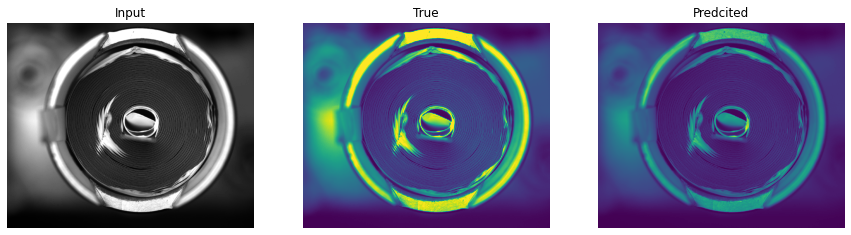

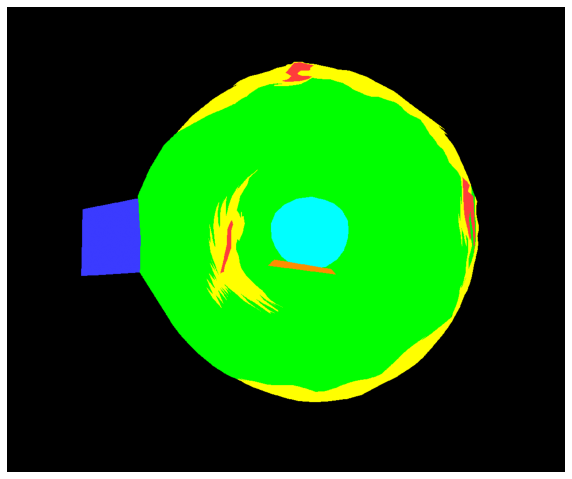

In [25]:
display([val_x[0], val_x[0], val_x[1]])
onehot_to_rgb(val_y[0])

In [26]:
sample_image = val_x[0]
sample_mask = val_y[0]

sample_image2 = val_x[1]
sample_mask2 = val_y[1]

print(sample_image.shape, sample_mask.shape)

(960, 1152, 1) (960, 1152, 1)


In [27]:
import tensorflow.keras.backend as K

train_y_onehot = tf.keras.utils.to_categorical(K.cast(train_y, tf.int32))
val_y_onehot = tf.keras.utils.to_categorical(K.cast(val_y, tf.int32))

print(train_y.shape, train_y_onehot.shape)

(340, 960, 1152, 1) (340, 960, 1152, 7)


찍힘 class에 가장 높은 weight, "눌림" class에 그 다음 높은 weight 적용

In [28]:
N = train_x.shape[0]

sample_weights = np.zeros((N,) + IMG_SIZE + (1,))
int_label = tf.expand_dims(np.argmax(train_y_onehot, axis=-1),-1)

#sample_weights_val = np.zeros(val_y.shape)

#bg_count = (np.array(train_y)==0).sum()
#stamp_count = (np.array(train_y)==4).sum()
#hole_count = (np.array(train_y)==2).sum()
#push_count = (np.array(train_y)==3).sum()
#circle_count = (np.array(train_y)==1).sum()

#denom = bg_count+circle_count+push_count+stamp_count+hole_count

#CLASS_WEIGHT = [(denom/bg_count).round(), (denom/circle_count).round(), (denom/hole_count).round(), 
#                (denom/push_count).round(), (denom/stamp_count).round() ]

#print(train_y.shape, val_y.shape)
# your own weight corresponding here:
#sample_weights[train_y==0] = 1                                                                                                       
#sample_weights[train_y==1] = 1                                                                                                               
#sample_weights[train_y==2] = 1                                                                                                             
#sample_weights[train_y==3] = 1
sample_weights[int_label==4] = 10

#print(sample_weights_val.shape, val_y.shape)
#sample_weights_val[val_y==0] = 1                                                                                                       
#sample_weights_val[val_y==1] = 1                                                                                                               
#sample_weights_val[val_y==2] = 1                                                                                                             
#sample_weights_val[val_y==3] = 1
#sample_weights_val[val_y==4] = 5  

print(np.unique(sample_weights), sample_weights.shape)

[ 0. 10.] (340, 960, 1152, 1)


In [29]:
print(train_x.shape, val_x.shape)

BUFFER_SIZE = train_x.shape[0]

train_ds = tf.data.Dataset.from_tensor_slices((train_x, train_y_onehot, sample_weights))
train_ds = train_ds.shuffle(buffer_size = BUFFER_SIZE-NUM_VAL).batch(BATCH_SIZE)

val_ds= tf.data.Dataset.from_tensor_slices((val_x, val_y_onehot))#, sample_weights))
val_ds = val_ds.shuffle(buffer_size = NUM_VAL).batch(BATCH_SIZE)

(340, 960, 1152, 1) (20, 960, 1152, 1)


Define Backbone model as well as segmentation model

In [30]:
from tensorflow.keras.layers import Conv2D, Input
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

sm.set_framework('tf.keras')
sm.framework()

def weighted_dice_coeff(y_true, y_pred, weight):
    smooth = 1.
    
    y_true = tf.one_hot(K.cast(y_true, tf.int32), depth=5) # K.layers.Flatten()(tf.one_hot(tf.cast(y_true, tf.int32), depth=5))
    y_true = y_true[:,:,:,0,:]
    
    #print(np.unique(ans),ans.shape)
    print(y_true.shape, y_pred.shape)
    #print(np.unique(np.array(y_true)), np.array(np.unique(y_pred)))
    
    w, m1, m2 = weight * weight, y_true, y_pred
    intersection = (m1 * m2)
    score = (2. * K.sum(w * intersection) + smooth) / (K.sum(w * m1) + K.sum(w * m2) + smooth)
    return score


def weighted_dice_loss(y_true, y_pred):
    #y_true = K.cast(y_true, 'float32')
    #y_pred = K.cast(y_pred, 'float32')
    # if we want to get same size of output, kernel size must be odd number
    if K.int_shape(y_pred)[1] == 128:
        kernel_size = 11
    elif K.int_shape(y_pred)[1] == 256:
        kernel_size = 21
    elif K.int_shape(y_pred)[1] == 512:
        kernel_size = 21
    elif K.int_shape(y_pred)[1] == 1024:
        kernel_size = 41
    elif K.int_shape(y_pred)[1] == 960:
        kernel_size = 21 
    else:
        raise ValueError('Unexpected image size')
    averaged_mask = K.pool2d(
        y_true, pool_size=(kernel_size, kernel_size), strides=(1, 1), padding='same', pool_mode='avg')
    border = K.cast(K.greater(averaged_mask, 0.005), 'float32') * K.cast(K.less(averaged_mask, 0.995), 'float32')
    weight = K.ones_like(averaged_mask)
    w0 = K.sum(weight)
    weight += border * 2
    w1 = K.sum(weight)
    weight *= (w0 / w1)
    loss = 1 - weighted_dice_coeff(y_true, y_pred, weight)
    return loss

if OPTIMIZER == "Adam":
    opt = keras.optimizers.Adam(learning_rate=LR) #default 0.001
elif OPTIMIZER == "RMSprop":
    opt = keras.optimizers.RMSprop(lr=LR) #default 0.001
    
if RGB: 
    ENC = 'imagenet'
    channel = 3
else: 
    ENC = None
    channel = 1
    
base_model = sm.PSPNet(BACKBONE, input_shape = IMG_SIZE + (3,), classes=7, encoder_weights='imagenet',
                      activation='softmax', encoder_freeze = ENC_FREEZE)

if not RGB:
    inp = Input(shape = IMG_SIZE + (1,) )

    l1 = Conv2D(3, (1,1))(inp) # map N channels data to 3 channels
    out = base_model(l1)

    model = Model(inp, out)
else:
    model = base_model

#model = sm.PSPNet(BACKBONE, input_shape = IMG_SIZE + (channel,), classes=5, encoder_weights=ENC, 
#                  activation=ACTIVATION, encoder_freeze = ENC_FREEZE)

model.compile(
    optimizer = opt,
    loss = sm.losses.DiceLoss(),
    #sm.losses.CategoricalFocalLoss(),#dice_score_loss,#tf.keras.losses.SparseCategoricalCrossentropy(from_logits=FROM_LOGITS), 
    metrics=['accuracy'], 
)

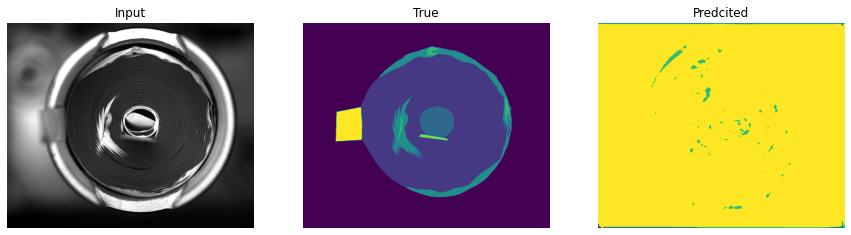

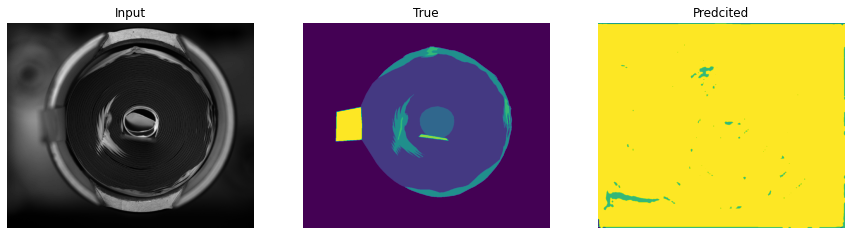

In [31]:
show_predictions()

In [32]:
import gc
import os
import datetime

#logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
#tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

gc.collect()

class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('{}에포크 이후의 예측 예시'.format(epoch+1))
    print ( 'Training Specifics: LR: {}, Validation size: {}, Image size: {}.'.format(LR, NUM_VAL,IMG_SIZE))
    print ('Current Accuracy: {}'.format(logs['accuracy']))
    print ('Validation Accuracy: {}'.format(logs['val_accuracy']))
    #tensorboard_callback
    #
    gc.collect()
    

For 960 1152 image size, works upto total 140 images.
(480,576) 3 augs
(960, 1152) 3 augs (46*4 image usued for training.)
(1440, 1920) no augmentations applied Batch size = 2 for all cases(46images used for training.)
(1200, x) works for 2augs,  with B=2 !

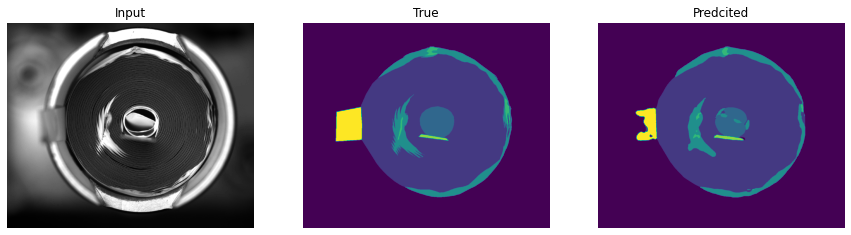

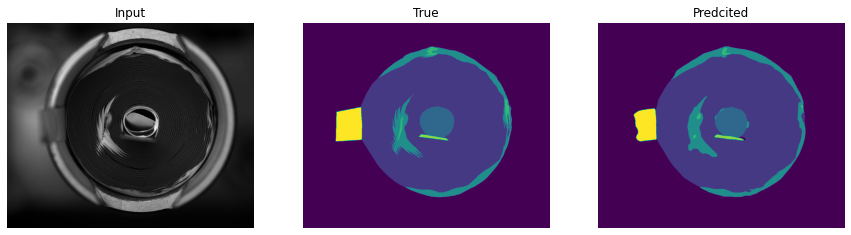

100에포크 이후의 예측 예시
Training Specifics: LR: 0.0001, Validation size: 20, Image size: (960, 1152).
Current Accuracy: 0.9940797686576843
Validation Accuracy: 0.9879209995269775
170/170 [==============================] - 44s 261ms/step - loss: 6.6781e-04 - accuracy: 0.9941 - val_loss: 0.1817 - val_accuracy: 0.9879


In [33]:
model_history = model.fit(train_ds,
                          epochs=EPOCHS,
                          validation_data = val_ds,
                          callbacks=[DisplayCallback()],)       
# 

In [ ]:
"""
BUFFER_SIZE = train_x.shape[0]

train_ds = tf.data.Dataset.from_tensor_slices((train_x, train_y))#, sample_weights))
train_ds = train_ds.shuffle(buffer_size = BUFFER_SIZE-NUM_VAL).batch(BATCH_SIZE)

val_ds= tf.data.Dataset.from_tensor_slices((val_x, val_y))#, sample_weights))
val_ds = val_ds.shuffle(buffer_size = NUM_VAL).batch(BATCH_SIZE)

sm.set_framework('tf.keras')
sm.framework()

if OPTIMIZER == "Adam":
    opt = keras.optimizers.Adam(learning_rate=LR) #default 0.001
elif OPTIMIZER == "RMSprop":
    opt = keras.optimizers.RMSprop(lr=LR) #default 0.001


model_2 = sm.PSPNet(BACKBONE, input_shape = IMG_SIZE + (1,), classes=5, encoder_weights=None, 
                  activation=ACTIVATION, encoder_freeze = ENC_FREEZE)

model_2.compile(
    optimizer = opt,
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=FROM_LOGITS), 
    metrics=['accuracy'], 
)

model_history_2 = model_2.fit(train_ds, 
                          epochs=EPOCHS,
                          validation_data = val_ds,
                          callbacks=[DisplayCallback()],)  
"""

In [ ]:
"""
%load_ext tensorboard
%tensorboard --logdir logs
from tensorboard import notebook
notebook.list() # View open TensorBoard instances
notebook.display(port=6006, height=1000) 
"""

In [ ]:
"""
test_x = []
test_y = []

for idx, img in enumerate(glob.glob("Original_Image/*.png")):

    n = cv2.imread(img)
    n = tf.cast(n, tf.float32) / 255.0
    n = tf.image.resize(n, IMG_SIZE)
    #n = tf.image.rgb_to_grayscale(n)
    
    n = tf.image.flip_left_right(n)
    
    test_x.append(n)

    #GET FILE NAME
    dir = "Mask_Image/" 
    file_name = img.split("/")[-1] 

    #MASK
    y = imread(dir+file_name)
    a = rgb_to_onehot(y, color_dict) #change to one hot

    bb = tf.expand_dims(np.argmax(a, axis=-1),-1) #combine one hot
    bbb = tf.image.resize(bb, IMG_SIZE)
    bbb = tf.image.flip_left_right(bbb)
    
    test_y.append(bbb)
    #
    if idx == 10: break

test_x = tf.convert_to_tensor(test_x)
test_y = tf.convert_to_tensor(test_y)

print(test_x.shape)
print(test_y.shape)
"""

In [ ]:
"""
test_x = []
test_y = []

with open("Val_img.txt") as f:
    for line in f:
        img = line.splitlines()[0]
        n = cv2.imread("JR_lower_part/Original_Image/" + img)
        n = tf.cast(n, tf.float32) / 255.0
        n = tf.image.resize(n, IMG_SIZE) 
        n = tf.image.flip_left_right(n)
        n = tf.image.rgb_to_grayscale(n)

        test_x.append(n)
        #MASK
        y = imread("JR_lower_part/Mask_Image/" + img) # imread(dir+file_name+".png")
        cc = cv2.inRange(y, (.99, 0, .99), (1,0,1))

        y[cc != 0] = [0,1,0]
        a = rgb_to_onehot(y, color_dict) #change to one hot

        bb = tf.expand_dims(np.argmax(a, axis=-1),-1) #combine one hot
        mask = tf.image.resize(bb, IMG_SIZE)
        mask = tf.image.flip_left_right(mask)

        test_y.append(mask)
        
test_x = tf.convert_to_tensor(test_x)
test_y = tf.convert_to_tensor(test_y)

print(test_x.shape, test_y.shape)    
"""

In testing Mode...


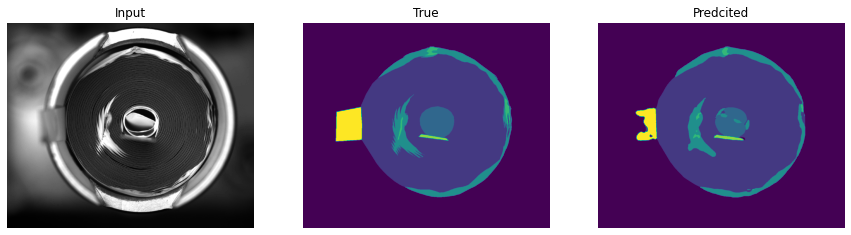

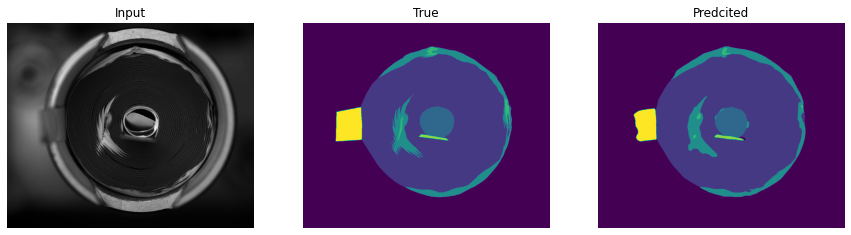

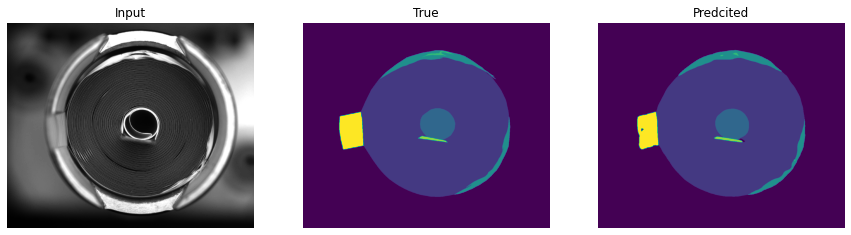

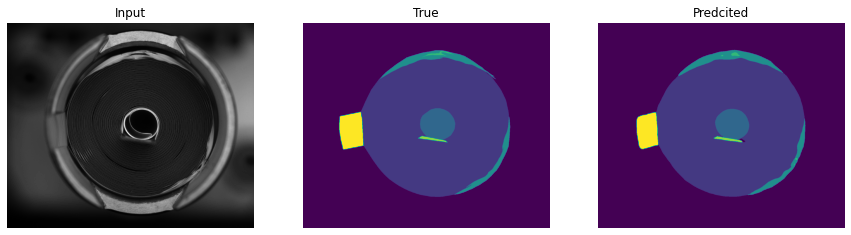

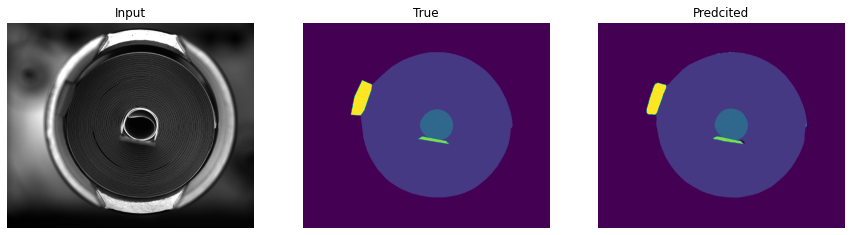

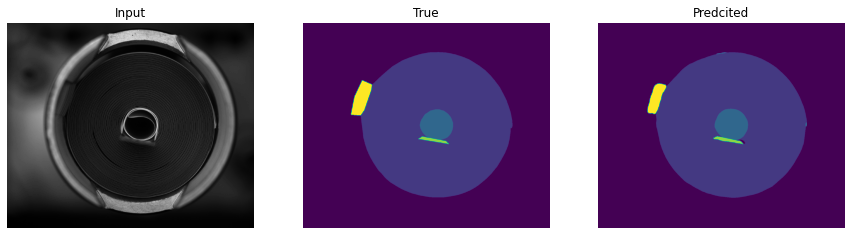

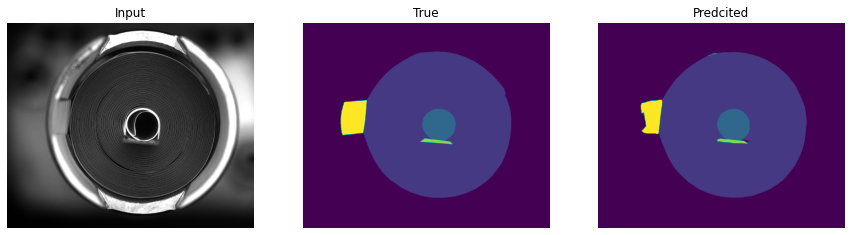

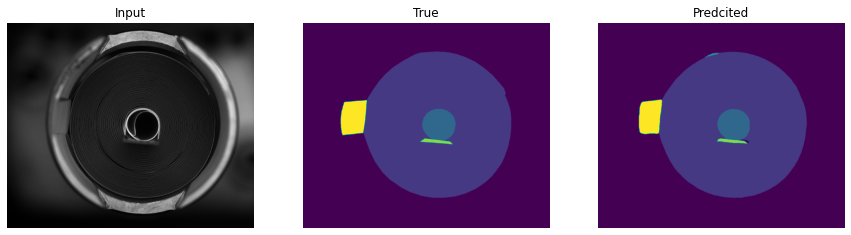

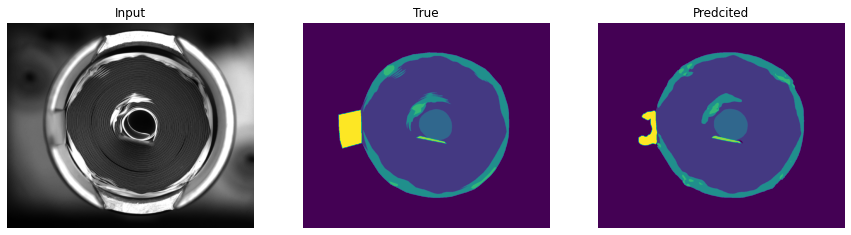

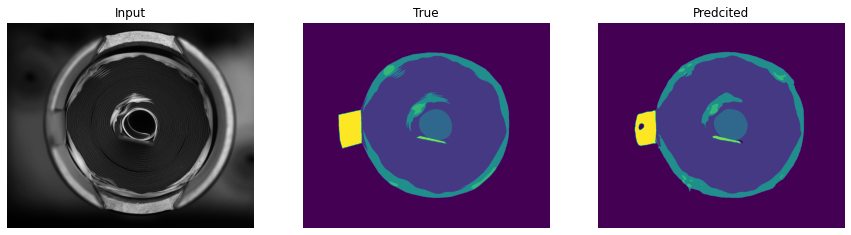

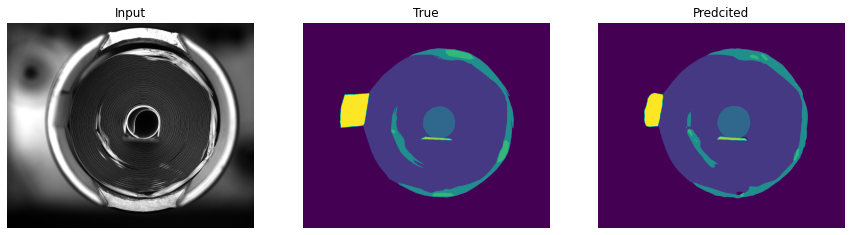

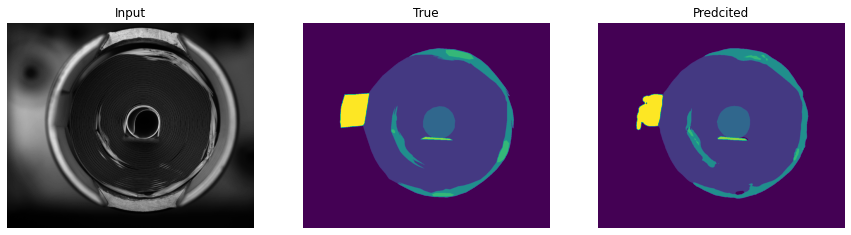

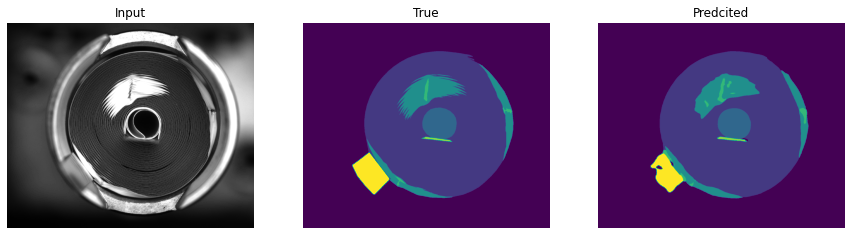

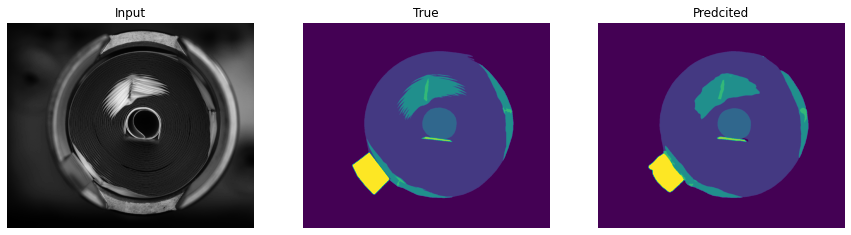

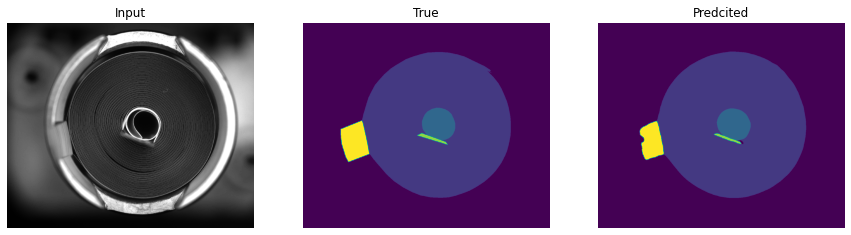

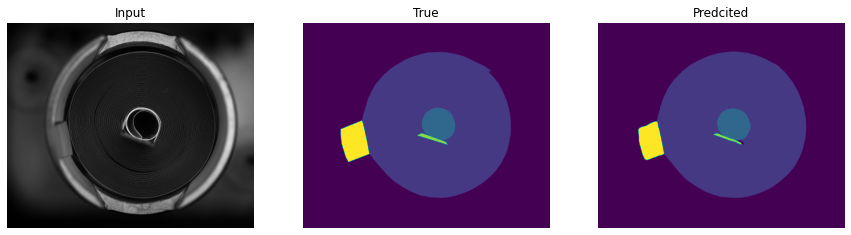

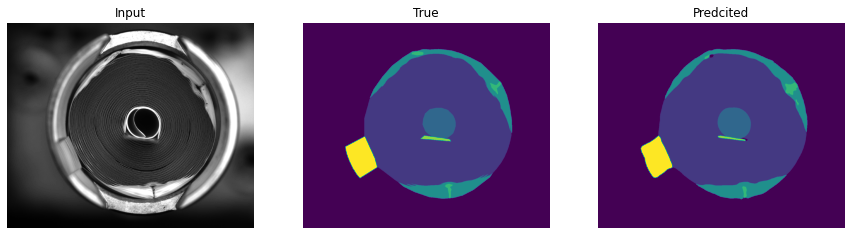

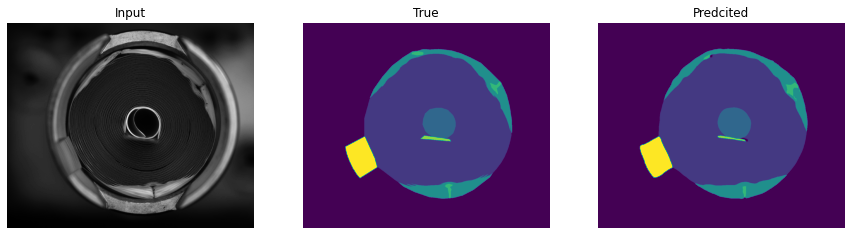

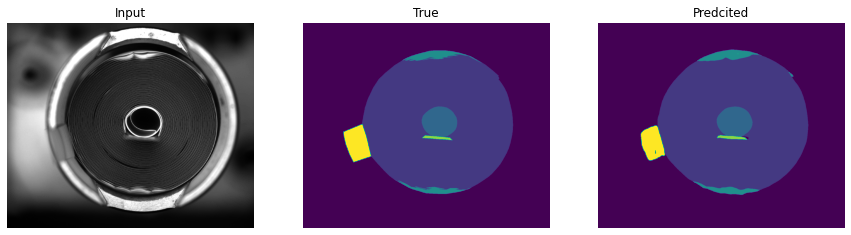

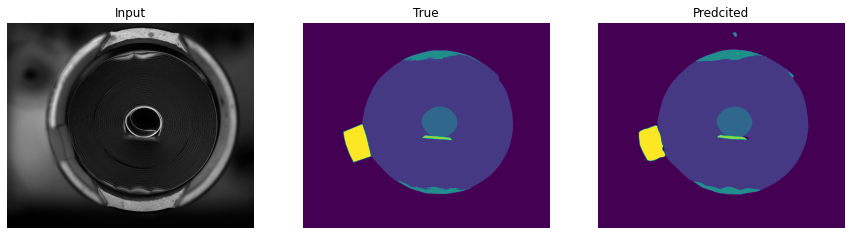

In [34]:
show_predictions(test_mode=True, x=val_x, y=val_y, num=20)

Finetuning with smaller learning rate (make whole model trainable)



In [ ]:
"""
model.trainable = True

if OPTIMIZER == "Adam":
    opt = keras.optimizers.Adam(learning_rate=LR/10) #default 0.001
elif OPTIMIZER == "RMSprop":
    opt = keras.optimizers.RMSprop(lr=LR/10) #default 0.001

model.compile(
    optimizer = opt,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=FROM_LOGITS), 
    metrics=['accuracy'],
)
"""

In [ ]:
"""
model_history_more = model.fit(train_ds, 
                          epochs=20,
                          validation_data = val_ds,
                          callbacks=[DisplayCallback()],)  
                          
show_predictions(test_mode=True, x=test_x, y=test_y, num=10)
"""

In [ ]:
"""
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
"""

In [ ]:
pred_mask = model.predict(val_x, batch_size=1)
aaa = create_mask(pred_mask, num=3)
dd = tf.one_hot(aaa, 5)
print(dd.shape)

In [ ]:
display([val_y[3], dd[:,:,:,1], dd[:,:,:,0]]) 
# 0 shows background, 1shows hole 2 shows "pushed", 3shows "Stamped", 4shows inner circle

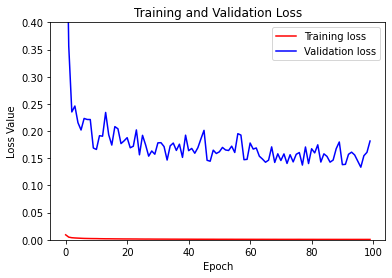

In [35]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 0.4])
plt.legend()
plt.show()

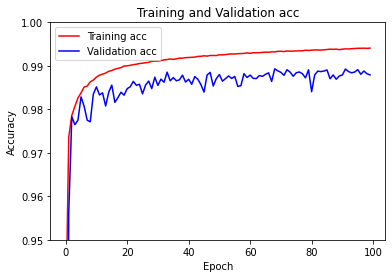

In [36]:
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.95,1])
plt.legend()
plt.show()

In [30]:
print("Training accuracy at the last epoch is:", np.round(model_history.history['val_accuracy'][-1],3))

Training accuracy at the last epoch is: 0.992


Saving Model for use in Inference

In [37]:
ACC = np.round(model_history.history['val_accuracy'][-1],3)
model.save('saved_model_1111_{}_RGB_{}_ACC_{}_{}'.format(IMG_SIZE, RGB, ACC, "3rd_data"))

#model.save('saved_model_1111_BN_RGB_False_{}'.format(IMG_SIZE))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saved_model_1111_(960, 1152)_RGB_False_ACC_0.988_3rd_data/assets
